## Analyze all single mutant neutralization data 
We neutralization curves with fully infectious Zika virus and a panel of broad neutralizing antibodies (bnAbs). These viruses were added to antibody titrations and incubated on Vero cells before intracellular E protein was measured via staining and flow cytometry. Here we will visualize those curves and draw lines at the various antibody dilutions we used in DMS (IC99 and greater) for figures in the paper.

In [1]:
# Import packages
import pandas as pd
import os
import numpy as np
import operator
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import neutcurve

In [2]:
# Set pandas display options
pd.set_option('display.float_format', '{:.4g}'.format)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

In [3]:
## ID sequences and locations
datadir = './data'
resultsdir ='./results'
os.makedirs(datadir, exist_ok = True)
os.makedirs(resultsdir, exist_ok = True)

# ID antibody and experiment number
ab_dict = {'ZV67': 'MC70',
           'MZ4': 'JBS039',
           'C10': 'MC70',
           'C8': 'CK016',
           'SIgN3C': 'MC70',
           }

### Calculate fraction infectivity
Based on Kate Crawford's SARS-CoV-2 JID paper, we get calculate fraction infectivity by dividing individual datapoints by the average of no-antibody or no-serum controls.

In [4]:
neutcurve_ls = []

for antibody in ab_dict:
    # ID sequence
    platereader_datafile = os.path.join(datadir,f'{antibody}_{ab_dict[antibody]}_neutdata.csv')
    platereader = pd.read_csv(platereader_datafile)
    
    # Get list of unique viruses and sort them by the mutated site
    viruses = []
    for item in platereader.columns:
        item = item.split('_')[0]
        if item != antibody:
            if item == 'WT':
                site = 0
            else:
                site = int(item[1:-1])
            viruses.append([item, site])
    viruses = sorted(list(set(tuple(row) for row in viruses)), key=lambda x: x[1])
    viruses = [i[0] for i in viruses]

    # Get list of concentrations
    concentrations = []
    for item in (platereader[f'{antibody}']):
        if item != 'no_ab':
            concentrations.append(item)

    # Caclulate fraction infectivity and then append to neutcurve_ls
    # Get no_ab average to utilize as denominator for fraction infectivity calculation
    # Then divide each value by this denominator
    # Save to reformatted dataframe to be parsed by neutcurve
    for v in viruses:
        rep1 = v + '_1'
        rep2 = v + '_2'

        replicates = (rep1, rep2, )
        no_ab_average = (platereader[[rep1,rep2,]].loc[platereader[antibody] == 'no_ab'].sum(axis=1)/len(replicates)).values[0]    
        
        # Add replicate number
        for i in range(0, 2):
            rep = i+1
            
            # Add concentration label
            for n in range(0, len(concentrations)):
                conc = concentrations[n]
                frac_infectivity = platereader[f'{v}_{rep}'][n] / no_ab_average
                
                # Neutcurve doesn't like 0's...?
                if frac_infectivity == 0:
                    frac_infectivity = 0.00000001

                neutcurve_ls.append([antibody, v, rep, conc, float(frac_infectivity)])


# Get dataframe with columns 'serum','virus','replicate','concentration','fraction infectivity'
# neutcurve is set up to accept only columns with these names
neutcurve_df = (pd.DataFrame(data=np.array(neutcurve_ls),
    columns=['serum','virus','replicate','concentration','fraction infectivity'])
                .astype({'fraction infectivity': 'float64', 'concentration': 'float64'})
               )

In [5]:
neutcurve_df['serum'] = (neutcurve_df['serum']
                         .str.replace('C10', 'EDE1-C10')
                         .str.replace('C8', 'EDE1-C8')
                         .str.replace('SIgN3C', 'SIgN-3C')
                         .str.replace('ZV67', 'ZV-67')
                        )


neutcurve_df.head(300)

,serum,virus,replicate,concentration,fraction infectivity
0,ZV-67,WT,1,10,0.01168
1,ZV-67,WT,1,2,0.02654
2,ZV-67,WT,1,0.4,0.1059
3,ZV-67,WT,1,0.08,0.3822
4,ZV-67,WT,1,0.016,0.6013
...,...,...,...,...,...
85,SIgN-3C,WT,2,0.016,0.86
86,SIgN-3C,WT,2,0.0032,1.13
87,SIgN-3C,WT,2,0.00064,1.059
88,SIgN-3C,WT,2,0.000128,1.061


### Fit Hill curves to data with neutcurve
Using the neutcurve documentation, we can produce replicate Hill curves and IC50s for our datasets. With the tables of IC50s, we can perform statistical tests. We can also plot these curves for figures for the paper. 

In [6]:
# Call CurveFits function from neutcurve
fits = neutcurve.CurveFits(neutcurve_df)
fits.replicates

{('ZV-67', 'WT'): ['1', '2', 'average'],
 ('MZ4', 'WT'): ['1', '2', 'average'],
 ('EDE1-C10', 'WT'): ['1', '2', 'average'],
 ('EDE1-C8', 'WT'): ['1', '2', 'average'],
 ('SIgN-3C', 'WT'): ['1', '2', 'average']}

In [7]:
verticals = {'EDE1-C10': [{'x':  .3, 'color': 'magenta'}],
             'EDE1-C8': [{'x':  1.8, 'color': 'magenta'}],
             'SIgN-3C': [{'x':  10, 'color': 'magenta'},
                        {'x':  20, 'color': 'magenta'}],
             'MZ4': [{'x':  4.8, 'color': 'magenta'}],
             'ZV-67': [{'x':  40, 'color': 'magenta'}]
            }

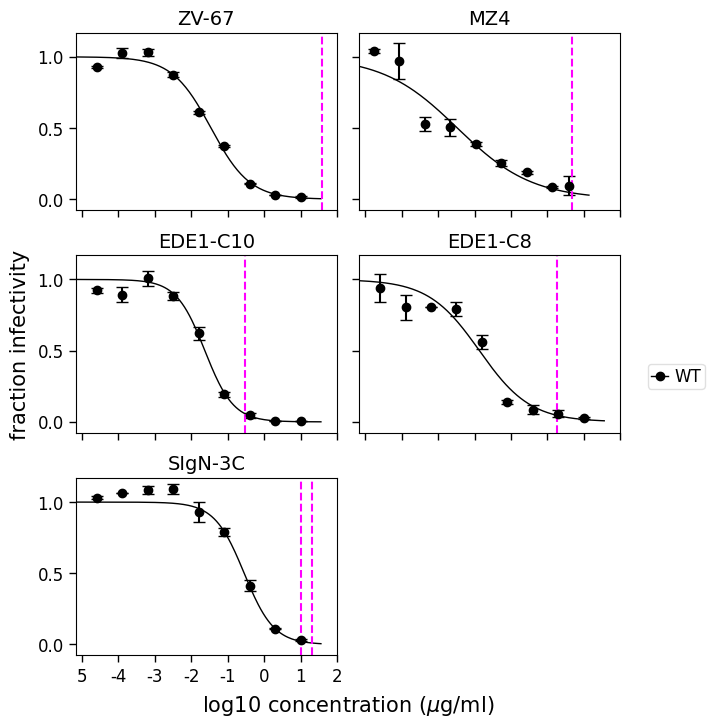

In [8]:
# For supplement, we might want to show all average curves
fig, axes = fits.plotSera(xlabel='log10 concentration ($\mu$g/ml)',
                          virus_to_color_marker = {'WT': ('black', 'o')},
                          ncol = 2,
                          vlines = verticals)

_ = axes.ravel()[-1].set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100,])
_ = axes.ravel()[-1].set_xticklabels(['5', '-4', '-3', '-2', '-1', '0', '1', '2', ])

_ = axes.ravel()[-1].set_yticks([0, 0.5, 1.0])
_ = axes.ravel()[-1].set_yticklabels(['0.0', '0.5', '1.0'])

neutfile = os.path.join(resultsdir, 'WT_MR766_vs_mAbs.pdf')
fig.savefig(neutfile, dpi='figure')

In [9]:
fits.fitParams(average_only=False)

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,midpoint,slope,top,bottom
0,ZV-67,WT,1,<NA>,0.03496,interpolated,0.035,0.03496,0.8161,1,0
1,ZV-67,WT,2,<NA>,0.03463,interpolated,0.0346,0.03463,0.8136,1,0
2,ZV-67,WT,average,2,0.03479,interpolated,0.0348,0.03479,0.8149,1,0
3,MZ4,WT,1,<NA>,0.003581,interpolated,0.00358,0.003581,0.3608,1,0
4,MZ4,WT,2,<NA>,0.003072,interpolated,0.00307,0.003072,0.5018,1,0
5,MZ4,WT,average,2,0.003373,interpolated,0.00337,0.003373,0.424,1,0
6,EDE1-C10,WT,1,<NA>,0.02121,interpolated,0.0212,0.02121,0.9321,1,0
7,EDE1-C10,WT,2,<NA>,0.02599,interpolated,0.026,0.02599,1.336,1,0
8,EDE1-C10,WT,average,2,0.0237,interpolated,0.0237,0.0237,1.107,1,0
9,EDE1-C8,WT,1,<NA>,0.01296,interpolated,0.013,0.01296,0.7023,1,0
